In [13]:
# Import Libraries

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU

In [4]:
# Load data
data = pd.read_csv('../data/stocks_clean.csv', index_col='Date', parse_dates=True)

In [5]:
# Normalise data

y = data['aapl_adj_close']
X = data.drop(columns=['aapl_adj_close'])

# Initialize the StandardScaler
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Fit and transform the features (X)
X_scaled = scaler_X.fit_transform(X)

# Convert the scaled X back to a DataFrame with original column names
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

# Fit and transform the target (y), needs to be reshaped as it's 1D
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Convert the scaled y back to a DataFrame to preserve column name
y_scaled = pd.DataFrame(y_scaled, columns=['aapl_adj_close'], index=y.index)

In [6]:
train_size = 0.8
ntrain = round(len(y) * 0.8)
ntest = len(y) - ntrain
X_train, X_test = X[:ntrain], X[ntrain:]
y_train, y_test = y[:ntrain], y[ntrain:]
print(f"Train size: {ntrain}, Test size: {ntest}")

Train size: 1416, Test size: 354


## Recurrent Neural Network Model #1 : Long Short-Term Memory (LSTM)

### Create sliding window sequences

In [7]:
def create_sequences(X, y, n_steps):
    """
    Create sliding window sequences for RNN models.
    
    :param X: Feature DataFrame
    :param y: Target series
    :param n_steps: Number of timesteps for each input sequence
    :return: Arrays of input sequences (X_seq) and corresponding targets (y_seq)
    """
    X_seq, y_seq = [], []
    for i in range(len(X) - n_steps):
        X_seq.append(X.iloc[i:i + n_steps].values)
        y_seq.append(y.iloc[i + n_steps])
    
    return np.array(X_seq), np.array(y_seq)

# Define sequence length (e.g., last 30 days to predict next day)
n_steps = 30

# Create sequences for train and test sets
X_train_seq, y_train_seq = create_sequences(X_train, y_train, n_steps)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, n_steps)

print(f"Training sequences shape: {X_train_seq.shape}, Target shape: {y_train_seq.shape}")

Training sequences shape: (1386, 30, 9), Target shape: (1386,)


### Build and train LSTM model

In [8]:
model_lstm = Sequential([
    LSTM(64, activation='relu', input_shape=(n_steps, X_train_seq.shape[2])),
    Dropout(0.2),
    Dense(1)  # Output layer for price prediction
])

model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history_lstm = model_lstm.fit(X_train_seq, y_train_seq, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 61790956.0000 - val_loss: 28171988.0000
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 21119878.0000 - val_loss: 6463739.0000
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 23136612.0000 - val_loss: 2853457.5000
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9816503.0000 - val_loss: 363319.4062
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7167865.0000 - val_loss: 16760.6719
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5140418.0000 - val_loss: 111595.7188
Epoch 7/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3983897.5000 - val_loss: 211546.6406
Epoch 8/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2772996.7500 - val_loss: 75384.3750
Epoch 9/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2002650.6250 - val_loss: 146637.5000
Epoch 10/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1648827.0000 - val_loss: 116983.6875


### Make predictions and evaluate performance

In [14]:
# LSTM Predictions and Evaluation
y_pred_seq_lstm = model_lstm.predict(X_test_seq)
y_pred_lstm = scaler_y.inverse_transform(y_pred_seq_lstm)
y_test_rescaled = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1))

# Calculate LSTM Metrics
rmse_lstm = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_lstm))
mae_lstm = mean_absolute_error(y_test_rescaled, y_pred_lstm)
mape_lstm = mean_absolute_percentage_error(y_test_rescaled, y_pred_lstm)

# Display LSTM Metrics
print(f"LSTM Model - RMSE: {rmse_lstm}, MAE: {mae_lstm}, MAPE: {mape_lstm}%")



11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
LSTM Model - RMSE: 38447.16669005094, MAE: 29057.17649061142, MAPE: 2.634215600954348%


### Visualisation of results

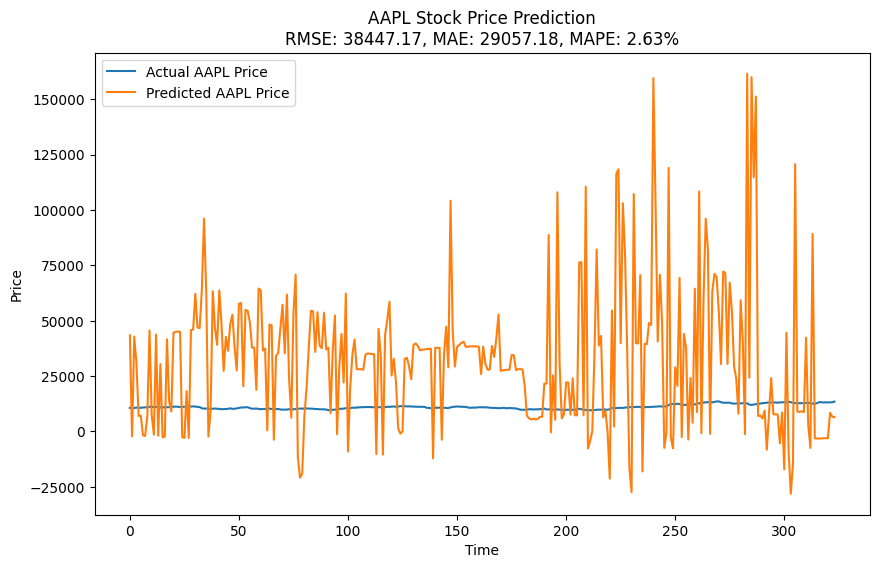

In [17]:
# Plot actual vs predicted prices with metrics in the title
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='Actual AAPL Price')
plt.plot(y_pred_lstm, label='Predicted AAPL Price')
plt.title(f'AAPL Stock Price Prediction\nRMSE: {rmse_lstm:.2f}, MAE: {mae_lstm:.2f}, MAPE: {mape_lstm:.2f}%')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [19]:
# Store metrics for different models
results = pd.DataFrame({
    'Model': ['LSTM'],
    'RMSE': [rmse_lstm],
    'MAE': [mae_lstm],
    'MAPE (%)': [mape_lstm]
})

print(results)


  Model         RMSE           MAE  MAPE (%)
0  LSTM  38447.16669  29057.176491  2.634216


## Recurrent Neural Network Model #2 : GRU

### Create sliding window sequences

In [20]:
def create_sequences(X, y, n_steps):
    """
    Create sliding window sequences for RNN models.
    
    :param X: Feature DataFrame
    :param y: Target series
    :param n_steps: Number of timesteps for each input sequence
    :return: Arrays of input sequences (X_seq) and corresponding targets (y_seq)
    """
    X_seq, y_seq = [], []
    for i in range(len(X) - n_steps):
        X_seq.append(X.iloc[i:i + n_steps].values)
        y_seq.append(y.iloc[i + n_steps])
    
    return np.array(X_seq), np.array(y_seq)

# Define sequence length (e.g., last 30 days to predict next day)
n_steps = 30

# Create sequences for train and test sets
X_train_seq, y_train_seq = create_sequences(X_train, y_train, n_steps)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, n_steps)

print(f"Training sequences shape: {X_train_seq.shape}, Target shape: {y_train_seq.shape}")

Training sequences shape: (1386, 30, 9), Target shape: (1386,)


### Build and train GRU model

In [21]:
# Define GRU model
model_gru = Sequential([
    GRU(64, activation='relu', input_shape=(n_steps, X_train_seq.shape[2])),
    Dropout(0.2),
    Dense(1)
])

model_gru.compile(optimizer='adam', loss='mean_squared_error')
history_gru = model_gru.fit(X_train_seq, y_train_seq, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 43219.1797 - val_loss: 11415.5596
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 14097.6562 - val_loss: 1605.6554
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9136.7090 - val_loss: 1522.7209
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7230.8677 - val_loss: 2566.8684
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6326.6992 - val_loss: 1390.9871
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4769.9604 - val_loss: 913.3442
Epoch 7/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3562.0586 - val_loss: 1337.0553
Epoch 8/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2705.5491 - val_loss: 1052.5778
Epoch 9/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2376.6313 - val_loss: 1155.5061
Epoch 10/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2050.1541 - val_loss: 1359.8322


### Make predictions and evaluate performance

In [22]:
# GRU Predictions and Evaluation
y_pred_seq_gru = model_gru.predict(X_test_seq)
y_pred_gru = scaler_y.inverse_transform(y_pred_seq_gru)

# Calculate GRU Metrics
rmse_gru = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_gru))
mae_gru = mean_absolute_error(y_test_rescaled, y_pred_gru)
mape_gru = mean_absolute_percentage_error(y_test_rescaled, y_pred_gru)

# Display GRU Metrics
print(f"GRU Model - RMSE: {rmse_gru}, MAE: {mae_gru}, MAPE: {mape_gru}%")


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
GRU Model - RMSE: 2236.2379337366997, MAE: 2125.447210095402, MAPE: 0.189417299514578%


### Visualise results

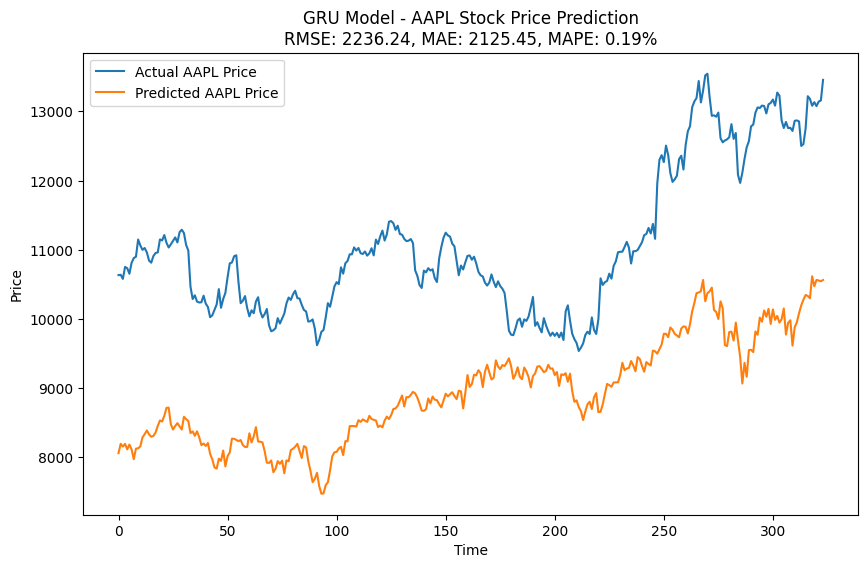

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='Actual AAPL Price')
plt.plot(y_pred_gru, label='Predicted AAPL Price')
plt.title(f'GRU Model - AAPL Stock Price Prediction\nRMSE: {rmse_gru:.2f}, MAE: {mae_gru:.2f}, MAPE: {mape_gru:.2f}%')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


## Comparison of results of Model #1: LSTM and Model #2: GRU

In [54]:
# Store metrics for LSTM and GRU
results = pd.DataFrame({
    'Model': ['LSTM', 'GRU'],
    'RMSE': [rmse_lstm, rmse_gru],
    'MAE': [mae_lstm, mae_gru],
    'MAPE (%)': [mape_lstm, mape_gru]
})

print(results)


  Model          RMSE           MAE  MAPE (%)
0  LSTM  38447.166690  29057.176491  2.634216
1   GRU   2236.237934   2125.447210  0.189417


# Evaluation of LSTM and GRU Models

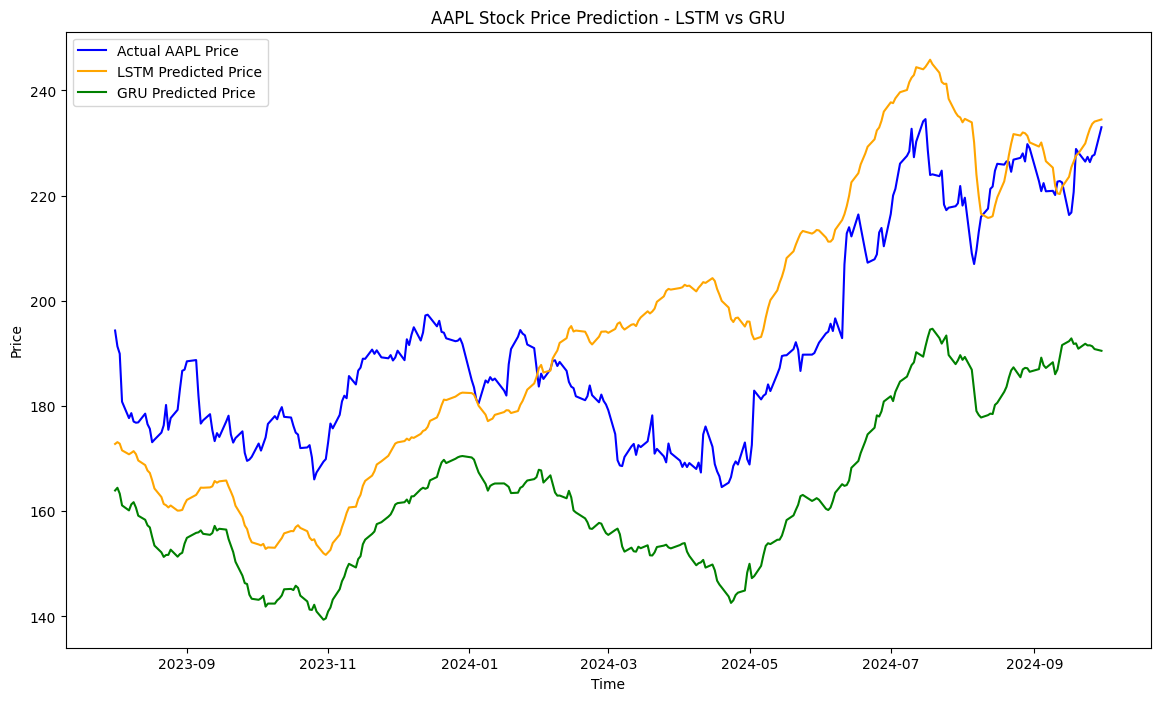

In [60]:
# Inverse transform y_test for evaluation
y_test_actual = scaler_y.inverse_transform(y_test_seq)

# Plot predictions
plt.figure(figsize=(14, 8))
plt.plot(y_test.index[n_steps:], y_test_actual, label='Actual AAPL Price', color='blue')
plt.plot(y_test.index[n_steps:], y_pred_lstm, label='LSTM Predicted Price', color='orange')
plt.plot(y_test.index[n_steps:], y_pred_gru, label='GRU Predicted Price', color='green')
plt.title('AAPL Stock Price Prediction - LSTM vs GRU')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

#### **Trend**
**LSTM**: The LSTM model follows the overall trend of the actual stock prices. The spikes and dips in prices are well-represented. However, it has some offsets numerically.

**GRU**: The GRU Model captures the general trend of actual stock prices, but consistently underpredicts the stock prices. It is less responsive to actual price changes and lags in magnitude and direction.


#### **Deviation and Offset**
**LSTM**: The LSTM model is more prone to a positive offset, i.e. overprediction.

**GRU**: The GRU Model is more prone to a negative offset, i.e. underprediction.


#### **Sensitivity to Volatility**
**LSTM**: The prediction of constantly higher prices could be due to a bias in the LSTM model.

**GRU**: This indicates that the GRU model is less capable of capturing the volatility and rapid changes in the stock prices, leading to conservative predictions.